# 03_Muhamad Adnan Aziz Al Hakim

# The Instruction
Create Customer 360 degree view dataset minimum 20 attributes. 1 Kaggle notebook, max 6 pages of A4 when printed in normal size (not zoomed out);

# The Answer:

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


# Read Table

In [2]:
customer = pd.read_csv('../input/brazilian-ecommerce/olist_customers_dataset.csv')
orders_detail = pd.read_csv('../input/brazilian-ecommerce/olist_order_items_dataset.csv')
payments = pd.read_csv('../input/brazilian-ecommerce/olist_order_payments_dataset.csv')
reviews = pd.read_csv('../input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
orders = pd.read_csv('../input/brazilian-ecommerce/olist_orders_dataset.csv')
geolocation = pd.read_csv('../input/brazilian-ecommerce/olist_geolocation_dataset.csv')
products_detail = pd.read_csv('../input/brazilian-ecommerce/olist_products_dataset.csv')
sellers = pd.read_csv('../input/brazilian-ecommerce/olist_sellers_dataset.csv')

# Reshape Tabels

In [3]:
customer_reshape = customer.loc[:, customer.columns != 'customer_zip_code_prefix']
products_detail_reshape = products_detail.loc[:, ['product_id', 'product_category_name', 'product_weight_g']]

sellers_reshape = sellers.loc[:, sellers.columns != 'seller_zip_code_prefix']

rreviews = reviews.loc[:, ['review_id', 'order_id', 'review_score', 'review_creation_date', 'review_answer_timestamp']]
reviews_sort = rreviews.sort_values(['review_creation_date', 'review_answer_timestamp'])
reviews_reshape = reviews_sort.drop_duplicates(['order_id'], keep = 'last')

orders_detail_sort = orders_detail.sort_values('order_id')
orders_detail_group = orders_detail_sort.groupby(['order_id', 'seller_id', 'product_id', 'price', 'freight_value'], as_index = False).agg({'order_item_id':'count'})
orders_detail_group.rename(columns ={'order_item_id':'qty'}, inplace = True)

payments_group = payments.groupby(['order_id', 'payment_type', 'payment_installments'], as_index = False).agg({'payment_sequential':'count', 'payment_value':'sum'})
payments_group.rename(columns = {'payment_sequential':'frequency'}, inplace = True)

# Table Merges

In [4]:
# Orders Detail Merges - Sucessfuly merge without added row
orders_detail_merge = orders_detail_group.merge(products_detail_reshape, on = 'product_id', how = 'left') \
                    .merge(sellers_reshape, on = 'seller_id', how = 'left')

# Order Merges - Sucessfully merge with added 2396, row order_id can contain > 1 payment methods
orders_merge = orders.merge(payments_group, on = 'order_id', how = 'left') \
                .merge(reviews_reshape, on = 'order_id', how = 'left')

# Order Merges Set - Sucessfully merge with added 3860 rows, order_id can contain > 1 payment method, > 1 product_id, or both
orders_merge_set = orders_merge.merge(orders_detail_merge, on = 'order_id', how = 'left')

# Customer Set - Sucessfully merge with added 2396 rows, customer_id can contain > 1 payment method, > 1 product_id, or both
customer_set = customer.merge(orders_merge_set, on = 'customer_id', how = 'left')

# **Imputation**

## **Categorical Data**
*To filling missing value in categorical columns, I decide to use mode because the mode represents the value that occurs most often in a dataset* 

In [5]:
customer_set.isna().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 162
order_delivered_carrier_date     1851
order_delivered_customer_date    3073
order_estimated_delivery_date       0
payment_type                        1
payment_installments                1
frequency                           1
payment_value                       1
review_id                         839
review_score                      839
review_creation_date              839
review_answer_timestamp           839
seller_id                         797
product_id                        797
price                             797
freight_value                     797
qty                               797
product_category_name            2299
product_weig

*As you can see on above, these categorical columns have missing value, like columns: payment_type, payment_installments, review_score, product_category_name, seller_city, and seller_state. So I begin to filling it on below:*

In [6]:
#payment_type column
customer_set.agg({'payment_type':'mode'})
customer_set['payment_type'].fillna('credit_card', inplace = True)

#payment_installments column
customer_set[orders_merge_set['payment_installments'].isnull()]
customer_set[orders_merge_set[['payment_type', 'payment_installments']]['payment_type'] == 'credit_card'].loc[:, ['payment_type', 'payment_installments']].mode()
customer_set['payment_installments'].fillna('1', inplace = True)

#product_category_name column
customer_set.agg({'product_category_name':'mode'})
customer_set['product_category_name'].fillna('cama_mesa_banho', inplace = True)

#seller_city column
customer_set.agg({'seller_city':'mode'})
customer_set['seller_city'].fillna('sao paulo', inplace = True)

#seller_state column
customer_set.agg({'seller_state':'mode'})
customer_set['seller_state'].fillna('SP', inplace = True)

#review_score column
customer_set.agg({'review_score':'mode'})
customer_set['review_score'].fillna(5, inplace = True)

## **Numerical Data**
*To filling missing value in numerical columns, I decide to use modian because the median is less affected by outliers and skewed data* 

In [7]:
customer_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105697 entries, 0 to 105696
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    105697 non-null  object 
 1   customer_unique_id             105697 non-null  object 
 2   customer_zip_code_prefix       105697 non-null  int64  
 3   customer_city                  105697 non-null  object 
 4   customer_state                 105697 non-null  object 
 5   order_id                       105697 non-null  object 
 6   order_status                   105697 non-null  object 
 7   order_purchase_timestamp       105697 non-null  object 
 8   order_approved_at              105535 non-null  object 
 9   order_delivered_carrier_date   103846 non-null  object 
 10  order_delivered_customer_date  102624 non-null  object 
 11  order_estimated_delivery_date  105697 non-null  object 
 12  payment_type                  

As you can see on above, order_approved_at, order_delivered_carrier_date, and order_delivered_customer_date columns is object. I will treat as numerical columns before that I have to convert to datetimes.

In [8]:
customer_set['order_approved_at'] = pd.to_datetime(customer_set['order_approved_at'])
customer_set['order_delivered_carrier_date'] = pd.to_datetime(customer_set['order_delivered_carrier_date'])
customer_set['order_delivered_customer_date'] = pd.to_datetime(customer_set['order_delivered_customer_date'])
customer_set['review_creation_date'] = pd.to_datetime(customer_set['review_creation_date'])
customer_set['review_answer_timestamp'] = pd.to_datetime(customer_set['review_answer_timestamp'])

#Convert succes
customer_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105697 entries, 0 to 105696
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    105697 non-null  object        
 1   customer_unique_id             105697 non-null  object        
 2   customer_zip_code_prefix       105697 non-null  int64         
 3   customer_city                  105697 non-null  object        
 4   customer_state                 105697 non-null  object        
 5   order_id                       105697 non-null  object        
 6   order_status                   105697 non-null  object        
 7   order_purchase_timestamp       105697 non-null  object        
 8   order_approved_at              105535 non-null  datetime64[ns]
 9   order_delivered_carrier_date   103846 non-null  datetime64[ns]
 10  order_delivered_customer_date  102624 non-null  datetime64[ns]
 11  

In [9]:
customer_set.isna().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 162
order_delivered_carrier_date     1851
order_delivered_customer_date    3073
order_estimated_delivery_date       0
payment_type                        0
payment_installments                0
frequency                           1
payment_value                       1
review_id                         839
review_score                        0
review_creation_date              839
review_answer_timestamp           839
seller_id                         797
product_id                        797
price                             797
freight_value                     797
qty                               797
product_category_name               0
product_weig

*As you can see on above, these numerical columns have missing value like columns: order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, review_creation_date, review_answer_timestamp,frequency, payment_value, price, freight_value, qty, product_weight_g. So I begin to filling it on below:*

In [10]:
#order_approved_at column
customer_set.agg({'order_approved_at':'median'})
customer_set['order_approved_at'].fillna('2018-01-18 13:34:44', inplace = True)

#order_delivered_carrier_date column
customer_set.agg({'order_delivered_carrier_date':'median'})
customer_set['order_delivered_carrier_date'].fillna('2018-01-23 21:49:11', inplace = True)

#order_delivered_customer_date column
customer_set.agg({'order_delivered_customer_date':'median'})
customer_set['order_delivered_customer_date'].fillna('2018-02-01 21:48:22', inplace = True)

#review_creation_date column
customer_set.agg({'review_creation_date':'median'})
customer_set['review_creation_date'].fillna('2018-02-01', inplace = True)

#review_answer_timestamp column
customer_set.agg({'review_answer_timestamp':'median'})
customer_set['review_answer_timestamp'].fillna('2018-02-04 04:52:34', inplace = True)

#frequency column
customer_set.agg({'frequency':'median'})
customer_set['frequency'].fillna('1', inplace = True)

#payment_value column
customer_set.agg({'payment_value':'median'})
customer_set['payment_value'].fillna('104.765', inplace = True)

#price column
customer_set.agg({'price':'median'})
customer_set['price'].fillna('78.575', inplace = True)

#freight_value column
customer_set.agg({'freight_value':'median'})
customer_set['freight_value'].fillna('16.34', inplace = True)

#qty column
customer_set.agg({'qty':'median'})
customer_set['qty'].fillna('1', inplace = True)

#product_weight_g column
customer_set.agg({'product_weight_g':'median'})
customer_set['product_weight_g'].fillna('663', inplace = True)

#Imputation end
customer_set.isna().sum()

customer_id                        0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
order_id                           0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date       0
order_delivered_customer_date      0
order_estimated_delivery_date      0
payment_type                       0
payment_installments               0
frequency                          0
payment_value                      0
review_id                        839
review_score                       0
review_creation_date               0
review_answer_timestamp            0
seller_id                        797
product_id                       797
price                              0
freight_value                      0
qty                                0
product_category_name              0
product_weight_g                   0
s

In [11]:
customer_set.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_type', 'payment_installments',
       'frequency', 'payment_value', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp', 'seller_id',
       'product_id', 'price', 'freight_value', 'qty', 'product_category_name',
       'product_weight_g', 'seller_city', 'seller_state'],
      dtype='object')

# Exploratory Data Analysis

In [12]:
pd.set_option('display.max_columns', None)

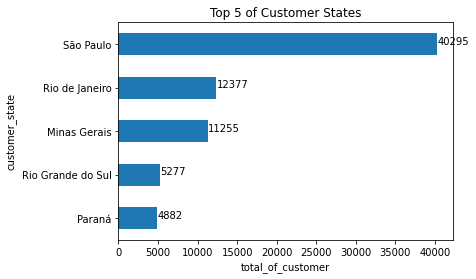

In [13]:
customer_reg = customer_set.loc[:, ['customer_unique_id', 'customer_city', 'customer_state']]
customer_reg.drop_duplicates('customer_unique_id', keep = 'first', inplace = True)

cust_bar = customer_reg.groupby(['customer_state'], as_index = False).agg({'customer_unique_id':'count'}).sort_values('customer_unique_id' ,ascending = False).head(5)
cust_bar.rename(columns = {'customer_unique_id':'num_of_customer'}, inplace = True)
cust_bar.replace({'SP':'São Paulo', 'RJ':'Rio de Janeiro', 'MG':'Minas Gerais', 'RS':'Rio Grande do Sul', 'PR':'Paraná'}, inplace = True)

#Visualize
cust_bar.sort_values('num_of_customer', ascending = True, ignore_index = True).plot(kind = 'barh', x = 'customer_state', y = 'num_of_customer', legend = None)
plt.xlabel('total_of_customer')
plt.title('Top 5 of Customer States')

num_iterates = cust_bar.loc[:, 'num_of_customer'].sort_values(ascending = True)
k = []

for index, value in num_iterates.items():
    k.append(value)
for index, value in enumerate(k):
    plt.text(value, index, str(value))

plt.show()

Based on the visualize, São Paulo leading on customer state with total 40295 users, follow by Rio de Janeiro and so on, São Paulo is the capital of the state of São Paulo, the most populous and wealthiest Brazilian state, located in the country's Southeast Region.

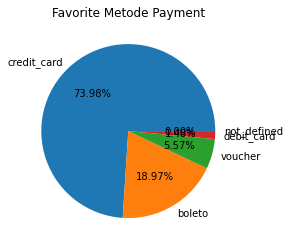

In [14]:
customer_pay = customer_set.loc[:, ['order_id', 'product_id','payment_type', 'frequency', 'payment_installments']]
customer_pay['frequency'] = customer_pay['frequency'].astype(int)

cus_pay_pie = customer_pay.groupby(['payment_type'], as_index = False).agg({'frequency':np.sum}).sort_values('frequency', ascending = False)
cus_pay_pie = customer_pay.groupby(['payment_type'], as_index = False)['frequency'].sum()
cus_pay_pie.sort_values(['frequency'], ascending = False, inplace = True, ignore_index = True)

#Visualize
plt.pie(cus_pay_pie['frequency'], labels = cus_pay_pie['payment_type'], autopct = '%.2f%%')
plt.title('Favorite Metode Payment')
plt.show()

Based on the visualize, credict card most used in Brazil. In March 2021, around six out of ten (62 percent of) m-commerce users surveyed in Brazil said their favorite way to pay for purchases made through a smartphone was credit card. (Statista, 2021) 

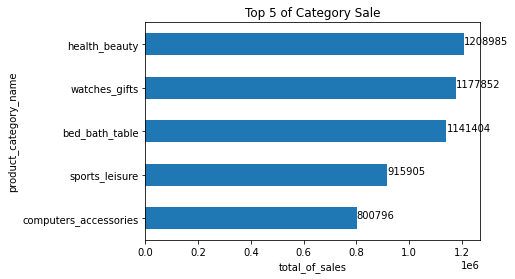

In [15]:
sales = customer_set.loc[:, ['order_id','product_category_name','price', 'order_status']]
sales = sales[sales['order_status'] == 'delivered']

top5_sales_category = sales.groupby('product_category_name', as_index = False).agg({'price':'sum'}).sort_values('price', ascending = False).head(5)
top5_sales_category.rename(columns = {'price':'sales'}, inplace = True)
top5_sales_category['sales'] = top5_sales_category['sales'].astype(int)
top5_sales_category.replace({'beleza_saude':'health_beauty', 'relogios_presentes':'watches_gifts', 'cama_mesa_banho':'bed_bath_table', 'esporte_lazer':'sports_leisure', 
                             'informatica_acessorios':'computers_accessories'}, inplace = True)

#Visualize
top5_sales_category.sort_values('sales', ascending = True, ignore_index = True).plot(kind = 'barh', x = 'product_category_name', y = 'sales', legend = None)
plt.xlabel('total_of_sales')
plt.title('Top 5 of Category Sale')

num_iterates = top5_sales_category.loc[:, 'sales'].sort_values(ascending = True)
k = []

for index, value in num_iterates.items():
    k.append(value)
for index, value in enumerate(k):
    plt.text(value, index, str(value))

plt.show()

Based on the visualize, health_beauty category leading with total 1,208,985 sales, followed by watches_gifts and so on. In 2021, women made almost six out of ten online purchases in Brazil. The share of e-commerce checkouts fulfilled by women has been increasing since 2019, when it stood at 52 percent. (Statista, 2022)

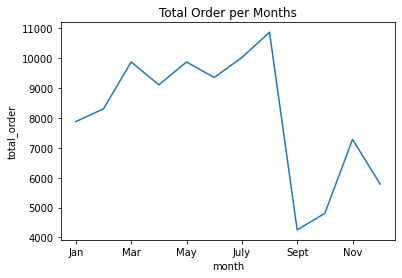

In [16]:
orders_time = customer_set.loc[:, ['order_id','order_status', 'order_approved_at']]
orders_time['order_status'].unique()
orders_time = orders_time[orders_time['order_status'].isin(['delivered', 'invoiced', 'shipped', 'processing', 'approved', 'created'])]
orders_time.drop_duplicates('order_id', keep = 'first', inplace = True)

orders_time['month_purchase'] = pd.to_datetime(orders_time['order_approved_at']).dt.month
orders_time['month_purchase'] = orders_time['month_purchase'].astype(str)
orders_time['month_purchase'].replace({'1':'Jan', '2':'Feb', '3':'Mar', '4':'Apr', '5':'May', '6':'Jun', '7':'Jul', '8':'Aug', '9':'Sep', '10':'Oct', '11':'Nov', '12':'Dec'}, inplace = True)

month_order1 = orders_time.groupby('month_purchase', as_index = False).agg({'order_id':'count'})

#I can not sort ascending based on month_purchase in month_order table so I create new dataframe and I can ascending based on month_purchase

month_purchase_dict = {'index':[1,2,3,4,5,6,7,8,9,10,11,12],
              'month_purchase':['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],
              'num_of_order':[7877, 8307, 9875, 9110, 9875, 9356, 10024, 10871, 4250, 4806, 7280, 5783]}

month_order2 = pd.DataFrame(month_purchase_dict)
month_order2.plot('month_purchase', 'num_of_order', legend = None)

plt.title('Total Order per Months')
plt.xlabel('month')
plt.ylabel('total_order')
plt.show()

Based on the visualize, on July until Augst their have most of high peak but in Sept number of order suddenly fall down.

# End - Thank for Your Attention